<a href="https://colab.research.google.com/github/nickwotton/MQP2019/blob/master/Nick/BSM_NN_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt to Replicate the Black Scholes Model Using a Neural Network


In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.stats as ss
import time

## Define the Function
Here we define our function, the Black Scholes Model (BSM). First, we must initialize the option class, then the Geometric Brownian Motion Class, and finally the BSM class.
Then we test the equation with a test value of 2.

In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype               # Put or Call
      self.strike = strike             # Strike K
      self.maturity = maturity         # Maturity T
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return np.max([0, (s - k)*otype])


In [0]:
'''============
Gbm class
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

In [0]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, vanilla_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity)) 
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity)) 
    return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

Gbm.bsm_price = bsm_price

In [0]:
'''=======
Get BSM prices given an option and a Tensor
======='''

def prices_bsm(self, vanilla_option, data):
  
  # Create the list
  a = []

  # Get tensor size
  sizeT = list(data.size())[0]

  for i in range(sizeT):
    self.init_state = data[i].item()
    callPrice = gbm1.bsm_price(vanilla_option)
    a.append(callPrice)
  
  # Convert to array then tensor
  arrayOut = np.array(a)
  outputData = torch.from_numpy(arrayOut)
  return outputData

Gbm.prices_bsm = prices_bsm

In [0]:
def f(s, k = 90):
  gbm = Gbm(init_state=s)
  option = VanillaOption(strike=k)
  return gbm.bsm_price(option)

batch_size = 63
x_list = np.linspace(0, 200, batch_size)
y_list = np.array([f(x) for x in x_list])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


## Create Model
Next, we create the neural network model. This is done first by setting the inner and outer dimensions with variables. Next we code the model and vary the internal dimensions to attempt to improve the model. At this level, this is essentially a simple linear algebra exercise:

If we have input $x$, internal parameters $a,b$, and solution $f(x)$ then in the one-dimensional case we have:

\begin{equation}
  \left(
    a_{1}x+b_{2}
  \right)
  a_{2} + b_{2}
  = f(x)
\end{equation}
  
However, we want to get a better estimate for the true equation. So we increase the interior dimension which corresponds to the number of neurons inside the network. For example, we raised the inner dimension to 3. In matrix form we have:

\begin{equation}
\left(
  \begin{bmatrix} x \end{bmatrix} 
  \begin{bmatrix} a_{1} & a_{2} & a_{3} \end{bmatrix} 
  + 
  \begin{bmatrix} b_{1} & b_{2} & b_{3} \end{bmatrix}
\right)
 \begin{bmatrix} a_{4} \\ a_{5} \\ a_{6} \end{bmatrix}
 +
 \begin{bmatrix} b_{4} \\ \end{bmatrix}
 =
 \begin{bmatrix} f(x) \end{bmatrix}
\end{equation}

Graphically, we can render this second neural network as:
![Neural Network Diagram](https://drive.google.com/uc?id=1ItiBpdjPvWHF5ZWy8JDNDKq6dXfyU-IE)

**ADD DESCRIPTION**

In [0]:
#model
#nn.Linear
H1 = 80; H2 = 20 #number of hidden layer
model = nn.Sequential(
    nn.Linear(1, H1), 
    nn.Sigmoid(),
    nn.Linear(H1, H2),
    nn.Sigmoid(),
    nn.Linear(H2,2),
    nn.Sigmoid(),
    nn.Linear(2,1)
)

Here we define the Loss function as the Mean Squared Error(MSE). 

Note that by doing so, we are essentially 'cheating' the system. In most applications, we would not know the function $f$ so we would be unable to find the MSE.

In [0]:
#loss function 
criterion = nn.MSELoss()

Next we choose a learning rate and a method for learning. The learning rate is the percent of the data that is accepted in each iteration. The Methods we tried were SGD and Adam. 

In [0]:
#optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) 

In [0]:
batch_size = np.size(x_list)
x_train0 = torch.from_numpy(x_list).reshape(batch_size,1).float()
y_train0 = torch.from_numpy(y_list).reshape(batch_size,1).float()

## Train the Model

First we create the training data. This is a batch of random points that we pass through the BSM.

Once we have the training data, we pass this collection of inputs and solutions into the model. With each iteration we calculate the loss and attempt to optimize the model to further reduce the loss.


In [0]:
# Normalization

def linear_transform(xx, l = 0, u= 1):
  M = torch.max(xx)
  m = torch.min(xx)
  return (u-l)/(M-m)*(xx-m)+l, m, M, l, u
x_train, x_m, x_M, x_l, x_u = linear_transform(x_train0, -1, 1)
y_train, y_m, y_M, y_l, y_u = linear_transform(y_train0, 0, 1)

In [0]:
# Train the model

num_epochs = 5000

for epoch in range(num_epochs):

    # Forward pass
    outputs = model(x_train.float())
    loss = criterion(outputs, y_train.float())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch == 0 or (epoch+1) % 50 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 
                                                    num_epochs, loss.item()))
        #print(outputs[1:10])
       
      


Epoch [1/5000], Loss: 0.2129
Epoch [50/5000], Loss: 0.1069
Epoch [100/5000], Loss: 0.1040
Epoch [150/5000], Loss: 0.0978
Epoch [200/5000], Loss: 0.0823
Epoch [250/5000], Loss: 0.0469
Epoch [300/5000], Loss: 0.0165
Epoch [350/5000], Loss: 0.0090
Epoch [400/5000], Loss: 0.0059
Epoch [450/5000], Loss: 0.0041
Epoch [500/5000], Loss: 0.0030
Epoch [550/5000], Loss: 0.0023
Epoch [600/5000], Loss: 0.0018
Epoch [650/5000], Loss: 0.0015
Epoch [700/5000], Loss: 0.0013
Epoch [750/5000], Loss: 0.0012
Epoch [800/5000], Loss: 0.0011
Epoch [850/5000], Loss: 0.0010
Epoch [900/5000], Loss: 0.0009
Epoch [950/5000], Loss: 0.0009
Epoch [1000/5000], Loss: 0.0009
Epoch [1050/5000], Loss: 0.0009
Epoch [1100/5000], Loss: 0.0008
Epoch [1150/5000], Loss: 0.0008
Epoch [1200/5000], Loss: 0.0008
Epoch [1250/5000], Loss: 0.0008
Epoch [1300/5000], Loss: 0.0008
Epoch [1350/5000], Loss: 0.0008
Epoch [1400/5000], Loss: 0.0007
Epoch [1450/5000], Loss: 0.0007
Epoch [1500/5000], Loss: 0.0007
Epoch [1550/5000], Loss: 0.0007

## Testing the Model


In [0]:
def learnedfun(x):
  out = (1-(-1))/(x_M-x_m)*(x-x_m)+(-1.)
  out = model(out)
  out = (y_M- y_m)*out+y_m
  return out

y_pred = learnedfun(x_train0)

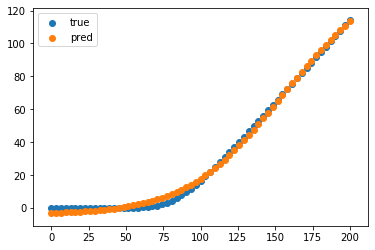

In [0]:
# Test with training data
plt.scatter(x_train0.detach().numpy(), y_train0.detach().numpy(), label='true')
plt.scatter(x_train0.detach().numpy(), y_pred.detach().numpy(), label='pred')

plt.legend()
plt.show()

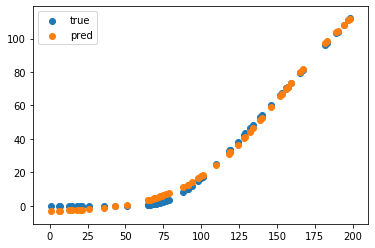

In [0]:
# Test the Model with Random data

# Generate random data
x_0 = np.random.randint(0, 200, batch_size) # MIGHT HAVE TO DO WITH THIS RANGE AND BATCH SIZE?

# Get BSM Prices as determined by the formula
y_0 = np.array([f(x) for x in x_0])

# Transform to tensor
x_0 = torch.from_numpy(x_0).reshape(batch_size,1).float()
y_0 = torch.from_numpy(y_0).reshape(batch_size,1).float()

# Normalize
x_, x_m, x_M, x_l, x_u = linear_transform(x_0)
y_, y_m, y_M, y_l, y_u = linear_transform(y_0)

# Plot x_ versus formula prices
plt.scatter(x_0.detach().numpy(), y_0.detach().numpy(), label='true')

# Get BSM Prices as determined by the model
y_pred = learnedfun(x_0)

# Plot x_ versus the model prices
plt.scatter(x_0.detach().numpy(), y_pred.detach().numpy(), label='pred')

plt.legend()


Put the above into a loop and check each number of neurons and layers

In [0]:
# Begin loop through each
# TODO Add time Checking
neuronsList = [[50,12],
               [50,12,10],
               [50,30],
               [50,50],
               [50,50,21],
               [50,100],
               [80,20],
               [100,80],
               [100,100],
               [100,120],
               [100,150],
               [500,100]]
for numNeurons in neuronsList:
  # Define the Model
  if len(numNeurons) == 2:
    H1 = numNeurons[0]; H2 = numNeurons[1] #number of hidden layer neurons
    model = nn.Sequential(
      nn.Linear(1, H1), 
      nn.Sigmoid(),
      nn.Linear(H1, H2),
      nn.Sigmoid(),
      nn.Linear(H2,2),
      nn.Sigmoid(),
      nn.Linear(2,1))
  else:
    H1 = numNeurons[0]; H2 = numNeurons[1]; H3 = numNeurons[2] #number of hidden layer neurons
    model = nn.Sequential(
      nn.Linear(1, H1), 
      nn.Sigmoid(),
      nn.Linear(H1, H2),
      nn.Sigmoid(),
      nn.Linear(H2,H3),
      nn.Sigmoid(),
      nn.Linear(H3,2),
      nn.Sigmoid(),
      nn.Linear(2,1))

  #loss function 
  criterion = nn.MSELoss()

  #optimizer
  learning_rate = 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7) 

  batch_size = np.size(x_list)
  x_train0 = torch.from_numpy(x_list).reshape(batch_size,1).float()
  y_train0 = torch.from_numpy(y_list).reshape(batch_size,1).float()

  # Normalization
  x_train, x_m, x_M, x_l, x_u = linear_transform(x_train0, -1, 1)
  y_train, y_m, y_M, y_l, y_u = linear_transform(y_train0, 0, 1)

  # Train the model

  print("Model: " + str(numNeurons))
  start = time.time()
  num_epochs = 5000

  for epoch in range(num_epochs):

      # Forward pass
      outputs = model(x_train.float())
      loss = criterion(outputs, y_train.float())
    
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      if epoch == 0 or (epoch+1) % 50 == 0:
          print ('Epoch [{}/{}], Loss: {:.8f}'.format(epoch+1, 
                                                      num_epochs, loss.item()))
          #print(outputs[1:10])
  end = time.time()
  timeEl = end-start
  print("Total Time Elapsed (s): " + str(timeEl))
  print("")

Model: [50, 12]
Epoch [1/5000], Loss: 0.33672205
Epoch [50/5000], Loss: 0.10862195
Epoch [100/5000], Loss: 0.10738762
Epoch [150/5000], Loss: 0.10563789
Epoch [200/5000], Loss: 0.10259616
Epoch [250/5000], Loss: 0.09643578
Epoch [300/5000], Loss: 0.08241504
Epoch [350/5000], Loss: 0.05174055
Epoch [400/5000], Loss: 0.01728370
Epoch [450/5000], Loss: 0.00771000
Epoch [500/5000], Loss: 0.00525315
Epoch [550/5000], Loss: 0.00392157
Epoch [600/5000], Loss: 0.00308993
Epoch [650/5000], Loss: 0.00253730
Epoch [700/5000], Loss: 0.00215737
Epoch [750/5000], Loss: 0.00189060
Epoch [800/5000], Loss: 0.00170050
Epoch [850/5000], Loss: 0.00156336
Epoch [900/5000], Loss: 0.00146328
Epoch [950/5000], Loss: 0.00138933
Epoch [1000/5000], Loss: 0.00133389
Epoch [1050/5000], Loss: 0.00129160
Epoch [1100/5000], Loss: 0.00125865
Epoch [1150/5000], Loss: 0.00123235
Epoch [1200/5000], Loss: 0.00121077
Epoch [1250/5000], Loss: 0.00119254
Epoch [1300/5000], Loss: 0.00117669
Epoch [1350/5000], Loss: 0.00116252